Documento elaborado por Carlos Rodríguez para su discusión en Kaggle y proponer diferentes formas de hacer las cosas. <br>
Juntos se aprende mejor.

### Nos aseguramos de descargar y instalar los paquetes necesarios en caso de correr en Jupiter Notebook

In [6]:
%%capture
!pip install matplotlib opencv-python watermark

### Importamos lo necesario

In [7]:
# Importamos las librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
from datetime import datetime

# Librerías del menú
import ipywidgets as widgets
from IPython.display import display

# para la generacion del archivo
from IPython.display import HTML
from google.colab import files
from google.colab import output
import zipfile
import tarfile

### Implementamos las funciones que generan imágenes.

In [8]:
def ra(h, low=0):
  return np.random.randint(low=low, high=h+1)

def img_rgb():

    img = np.zeros((100, 100, 3), dtype=np.uint8)

    # Generamos el color del fondo.
    img[:,:,0] = ra(255)
    img[:,:,1] = ra(255)
    img[:,:,2] = ra(255)

    # Generamos los colores de las formas.
    r, g , b = ra(255), ra(255), ra(255)

    return img , r ,g ,b

def draw_equilateral_triangle():

    side_length = ra(60,30)
    img , r ,g ,b = img_rgb()

    # Generar una posición aleatoria dentro del rango (0-100) para el triángulo
    x = random.randint(10, 80 )
    y = random.randint(10, 80 )

    # Calcular las coordenadas de los vértices del triángulo
    height = (np.sqrt(3) / 2) * side_length
    half_side = side_length / 2
    vertex1 = (int(x - half_side), int(y + height / 3))
    vertex2 = (int(x + half_side), int(y + height / 3))
    vertex3 = (int(x), int(y - (2 * height / 3)))

    # Dibujar las líneas del triángulo
    cv2.line(img, vertex1, vertex2, (r,g,b) , 2)
    cv2.line(img, vertex2, vertex3, (r,g,b) , 2)
    cv2.line(img, vertex3, vertex1, (r,g,b) , 2)

    return img , "triangle"

def draw_circle():

    radius =ra(50,20)
    img , r ,g ,b = img_rgb()

    x = random.randint(0, 100 )
    y = random.randint(0, 100 )

    cv2.circle(img, center=(x, y), radius=radius, color=(r, g, b), thickness=2)

    return img , "circle"

def draw_line():

    length = ra(50,20)
    img , r ,g ,b = img_rgb()

    x = ra(70)
    y = ra(70)
    angle = random.uniform(0, 2*math.pi)  # Ángulo aleatorio en radianes

    # Cálculo de las coordenadas finales de la línea
    x2 = int(x + length * math.cos(angle))
    y2 = int(y + length * math.sin(angle))

    cv2.line(img, pt1=(x, y), pt2=(x2, y2), color=(r, g, b), thickness=3)

    return img, "line"

def draw_rectangle():

    img , r ,g ,b = img_rgb()

    x = random.randint(0, 90 )
    y = random.randint(0, 90 )

    # Cálculo de las coordenadas finales de la línea
    x2 = int(x + 20 + ra(30))
    y2 = int(y + 20 + ra(30))

    cv2.rectangle(img, pt1=(x, y), pt2=(x2, y2), color=(r, g, b), thickness=3)

    return img , "rectangle"

figures = ["line", "rectangle", "circle", "triangle"]

# Una imagen de muestra para cada función

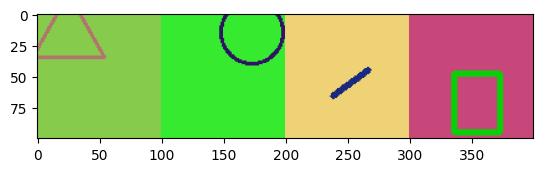

In [9]:
img_1, _ = draw_equilateral_triangle()
img_2, _  = draw_circle()
img_3, _  = draw_line()
img_4, _  = draw_rectangle()
ver = np.hstack((img_1, img_2, img_3, img_4))

plt.imshow(ver);

# Creado el Dataset.

Vamos a crear una interface para generar diferetnes tipos de DataSets.

In [10]:
#@markdown Configuración general.
#@markdown ---

triangulos= True #@param {type:"boolean"}
circulos = True #@param {type:"boolean"}
lineas  = True #@param {type:"boolean"}
rectangulos = True #@param {type:"boolean"}

cantidad_train = 30000 #@param {type:"integer"}
cantidad_test = 10000 #@param {type:"integer"}

#@markdown Configuración archivo de salida.
#@markdown ---

nombe_dataset = 'formas' #@param {type:"string"}
#@markdown Agregamos la fecha al archivo de salida?
fecha_hora = True #@param {type:"boolean"}
#@markdown Formato ?
extension = '.zip' #@param [".zip", ".tar", ".gz"]


args = [triangulos,       # 0
        circulos,         # 1
        lineas,           # 2
        rectangulos,      # 3
        rectangulos,      # 4
        cantidad_train,   # 5
        cantidad_test,    # 6
        nombe_dataset,    # 7
        fecha_hora,       # 8
        extension]        # 9


button = widgets.Button(description="Generar DataSet")
output = widgets.Output()

def agregar_funciones_a_lista(funciones, *args):
    lista_funciones = []
    for i in range(len(args)):
        if args[i]:
            lista_funciones.append(funciones[i])
    return lista_funciones

def generar_y_guardar(args, modo):

    # Calculando cantidades de train y test.
    total_imagenes_train = args[5]
    total_imagenes_test = args[6]

    if modo == "train":
      print('\n',"Generando el los datos de train.")
      print("El total de imágenenes para train es: " , total_imagenes_train, '\n')
    else:
      print('\n',"Generando el los datos de test.")
      print("El total de imágenenes para test es: " , total_imagenes_test, '\n')

    # Verificamos si queremos incluir fecha al dataset
    if args[8] == True:
      now = datetime.now()
      fecha_hora = str(now.strftime("%Y-%m-%d_%H-%M"))
      nombre_dir = args[7]+"_"+fecha_hora
    else:
      nombre_dir = args[7]

    # Creamos el directorio principal
    try:
        os.makedirs(nombre_dir, exist_ok=True)
        print(f"Se ha creado el directorio '{nombre_dir}'.")
    except OSError as error:
        print(f"No se pudo crear el directorio '{nombre_dir}': {error}")


    # Vemos que imágenes se deben generar.
    funciones = [draw_equilateral_triangle, draw_circle, draw_line,draw_rectangle]
    booleanos = [args[0],args[1],args[2],args[3]]
    funciones_agregadas = agregar_funciones_a_lista(funciones, *booleanos)

    cantidad_categorias = len(funciones_agregadas)

    # Generamos las imágenes de train para cada categoía seleccionada.
    for i in range(cantidad_categorias):

        cantidad_por_categoria = int(total_imagenes_train/cantidad_categorias)

        for n in range(cantidad_por_categoria):

          # Generando la imagen
          img, tipo  = funciones_agregadas[i]()

          # Guardar la imagen en el directorio especificado
          # Directorio de destino de la imagen
          directorio = nombre_dir+'/'+modo+'/'+ tipo
          # Crear directorios si no existen
          os.makedirs(directorio, exist_ok=True)
          ruta_guardado = os.path.join(directorio, tipo+str(n)+'.jpg')
          cv2.imwrite(ruta_guardado, img)


          # ---- Mostrando el datos ---------------------------------------------
          # Calcular el progreso actual
          progreso = (n + 1) / cantidad_por_categoria
          # Verificar si el progreso es un incremento de 10%
          if progreso % 0.1 == 0:
              # Calcular el número de caracteres iguales en la barra de carga
              num_caracteres = int(progreso * 20)
              # Construir la barra de carga
              barra = "[" + "=" * num_caracteres + " " * (20 - num_caracteres) + "]"
              # Imprimir la barra de carga
              print(f"Progreso: {barra} {progreso*100:.1f}%")


        # Imprimir el 100% de progreso
        print("Progreso: [====================] 100.0%")

def generar_archivo(args):
    print('\nPreparando la descarga')

    if args[8] == True:
        now = datetime.now()
        fecha_hora = str(now.strftime("%Y-%m-%d_%H-%M"))
        nombre_dir = args[7] + "_" + fecha_hora
    else:
        nombre_dir = args[7]

    extension = args[9]

    directorio = nombre_dir  # Ruta completa del directorio a comprimir

    if extension == '.zip':
        archivo = nombre_dir + '.zip'
        with zipfile.ZipFile(archivo, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Recorrer los archivos y carpetas dentro del directorio
            for root, _, files in os.walk(directorio):
                for file in files:
                    # Ruta completa del archivo
                    archivo_completo = os.path.join(root, file)
                    # Ruta relativa dentro del directorio a comprimir
                    ruta_relativa = os.path.relpath(archivo_completo, directorio)
                    # Agregar el archivo al ZIP con su ruta relativa
                    zipf.write(archivo_completo, arcname=ruta_relativa)
    elif extension == '.tar':
        archivo = nombre_dir + '.tar'
        with tarfile.open(archivo, 'w') as tar:
            tar.add(directorio)
    elif extension == '.gz':
        archivo = nombre_dir + '.tar.gz'
        with tarfile.open(archivo, 'w:gz') as tar:
            tar.add(directorio)

    # Verificar si el archivo se ha generado correctamente
    if os.path.isfile(archivo):
        print('Archivo generado correctamente:', archivo)
    else:
        print('No se pudo generar el archivo.')


    # Descargar el archivo
    from google.colab import files # por algúna razon si lo saco de aca no anda..
    files.download(archivo)
    '''
    # Generar el enlace
    nombre_enlace = 'Descargar archivo'
    enlace = f'<a href="{archivo}" download="{archivo}">{nombre_enlace}</a>'
    # Renderizar el enlace como HTML
    display(HTML(enlace))
    '''

def on_button_clicked(button_event, args):
  # Display the message within the output widget.
  with output:
    generar_y_guardar(args, "train")
    generar_y_guardar(args, "test")
    generar_archivo(args)



button.on_click(lambda event: on_button_clicked(event, args))
display(button, output)

Button(description='Generar DataSet', style=ButtonStyle())

Output()

<br><br><br><br><br>

### En caso de querer borrar todo

In [11]:
import os,shutil

# Obtener la ruta de la carpeta actual
ruta_actual = os.getcwd()

# Listar todos los elementos de la carpeta actual
elementos = os.listdir(ruta_actual)

print(elementos)

for elemento in elementos:
    ruta_elemento = os.path.join(ruta_actual, elemento)
    if os.path.isfile(ruta_elemento):
        os.remove(ruta_elemento)
        print(f"Archivo '{elemento}' eliminado.")
    elif os.path.isdir(ruta_elemento):
        shutil.rmtree(ruta_elemento)
        print(f"Carpeta '{elemento}' eliminada.")

['formas_2023-07-02_06-15', 'formas_2023-07-02_06-15.zip']
Carpeta 'formas_2023-07-02_06-15' eliminada.
Archivo 'formas_2023-07-02_06-15.zip' eliminado.
